### A2C agent.

Necessary libraries.

In [421]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import chainer
from chainer import Chain
import chainer.functions as F
import chainer.links as L

import gym

Initial shared model architecture.

In [422]:
class MLP(Chain):
    
    def __init__(self, obs_size, n_units=64):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l0 = L.Linear(obs_size, n_units)
            self.l1 = L.Linear(n_units, 2 * n_units)
            self.l2 = L.Linear(2 * n_units, n_units)
            
    def __call__(self, x):
        h = F.relu(self.l0(x))
        h = F.relu(self.l1(h))
        return F.relu(self.l2(h))  

Model architecture for the A2C agent.

In [423]:
class ActorCritic(Chain):
    
    def __init__(self, shared_model, n_actions):
        
        super(ActorCritic, self).__init__()
        with self.init_scope():
            self.shared_model = shared_model
            
            self.actor = L.Linear(None, n_actions)
            self.critic = L.Linear(None, 1)
    
    
    def __call__(self, x):
        h = self.shared_model(x)
    
        pi = F.softmax(self.actor(h))
        v = self.critic(h)
        return pi, v

Model architecture for non-shared policy and value function (actor and critic).

In [424]:
class ActorCriticSeparate(Chain):
    
    def __init__(self, model_actor, model_critic, n_actions):
        
        super(ActorCriticSeparate, self).__init__()
        with self.init_scope():
            self.model_actor = model_actor
            self.model_critic = model_critic
            
            self.actor = L.Linear(None, n_actions)
            self.critic = L.Linear(None, 1)
    
    
    def __call__(self, x):
    
        pi = F.softmax(self.actor(self.model_actor(x)))
        v = self.critic(self.model_critic(x))
        return pi, v

A2C agent class with necessary methods.

In [428]:
class A2CAgent(object):
    
    def __init__(self, model, optimizer, n_steps, gamma, phi=lambda x: x, 
                 pi_loss_coef=1.0, v_loss_coef=0.5,
                 average_actor_loss_decay=0.999,
                 average_value_decay=0.999,
                 average_entropy_decay=0.999,
                 entropy_coeff=0.01
                ):
        
        self.model = model
        self.optimizer = optimizer
        self.n_steps = n_steps
        self.gamma = gamma
        self.phi = phi
        self.pi_loss_coef = pi_loss_coef
        self.v_loss_coef = v_loss_coef
    
        self.step = 0
        self.start_step = 0
    
        self.average_actor_loss_decay = average_actor_loss_decay
        self.average_value_decay = average_value_decay
        self.average_entropy_decay=average_entropy_decay
        self.entropy_coeff = entropy_coeff
    
        # Stats
        self.average_actor_loss = 0.0
        self.average_value = 0.0
        self.average_entropy = 0.0
    
    def _compute_returns(self, next_value):
        
        self.returns[-1] = next_value
        for i in reversed(range(self.n_steps)):
            self.returns[i] = self.rewards[i] + \
                self.gamma * self.returns[i + 1]
    
    def _reset_storage(self, state, p_out):

        self.states = np.zeros((self.n_steps + 1,) + state.shape, dtype=np.float32)
        self.action_log_probs = np.zeros(self.n_steps, dtype=np.float32)
        self.rewards = np.zeros(self.n_steps, dtype=np.float32)
        self.value_preds = np.zeros(self.n_steps + 1, dtype=np.float32)
        self.returns = np.zeros(self.n_steps + 1, dtype=np.float32)
    
    def update(self):
        _, next_value = self.model(self.states[-1])
        next_value = next_value.data

        self._compute_returns(next_value)
        p_out, values = self.model(chainer.Variable(self.states[:-1]))

        dist_entropy =  - F.sum(F.exp(self.action_log_probs) * self.action_log_probs)#, axis=1)
        
        advantages = chainer.Variable(self.returns[:-1].reshape(-1, 1)) - values
        value_loss = F.mean(advantages * advantages)
        action_loss = - F.mean(chainer.Variable(advantages.data) * self.action_log_probs.reshape(-1, 1))
        
        self.model.cleargrads()

        (value_loss * self.v_loss_coef +
         action_loss * self.pi_loss_coef
         - dist_entropy * self.entropy_coeff).backward()
            
        self.optimizer.update()
        self.states[0] = self.states[-1]
        self.start_step = self.step
        
        # Update stats
        self.average_actor_loss += (
            (1 - self.average_actor_loss_decay) *
            (action_loss.data.astype(np.float32) - self.average_actor_loss))
        self.average_value += (
            (1 - self.average_value_decay) *
            (value_loss.data.astype(np.float32) - self.average_value))
        self.average_entropy += (
            (1 - self.average_entropy_decay) *
            (dist_entropy.data.astype(np.float32) - self.average_entropy))

    
    
    def act_and_train(self, state, reward, done):

        state = self.phi(state)
        
        if self.step == 0:
            p_out, _ = self.model(state)
            action = np.random.choice(n_actions, p=p_out.data.flatten())
            self._reset_storage(state, p_out)

        self.rewards[self.step - self.start_step - 1] = np.array(reward, dtype=np.float32)
        self.states[self.step - self.start_step] = state

        if self.step - self.start_step == self.n_steps:
            self.update()
            
        p_out, value = self.model(state)
        action = np.random.choice(n_actions, p=p_out.data.flatten())

        self.action_log_probs[self.step - self.start_step] = F.log(p_out)[0][action].data
        self.value_preds[self.step - self.start_step] = value.data

        self.step += 1
            
        return action
    
    def act(self, obs):

        pass
    
    def stop_episode_and_train(self, state, reward, done=False):
        
        state = self.phi(state)
        self.rewards[self.step - self.start_step - 1] = np.array(reward, dtype=np.float32)
        self.states[self.step - self.start_step] = state

        self.update()
            
    def get_statistics(self):
        return [
            ('average_actor_loss', self.average_actor_loss),
            ('average_value', self.average_value),
            ('average_entropy', self.average_entropy)
        ]

Training on CartPole-v0 for testing and debugging.

In [429]:
env = gym.make('CartPole-v0')
obs_size = env.observation_space.low.size
n_actions = env.action_space.n
n_steps = 20
n_episodes = 20000

model = ActorCriticSeparate(model_actor=MLP(obs_size), model_critic=MLP(obs_size), n_actions=n_actions)
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.GradientClipping(40))

preprocessor = lambda x: x.astype(np.float32).reshape((-1,) + x.shape)
agent = A2CAgent(model=model, optimizer=optimizer, gamma=0.99, n_steps=n_steps, phi=preprocessor)

rewards_per_episode = []
average_value_per_episode = []
average_actor_loss_per_episode = []
average_entropy_per_episode = []

for i in range(1, n_episodes + 1):
    obs = env.reset()
    reward = 0
    done = False
    R = 0 
    t = 0
    while not done:
        # env.render()
        action = agent.act_and_train(obs, reward, done)
        obs, reward, done, _ = env.step(action)
        R += reward
        t += 1
    rewards_per_episode.append(R)
    average_value_per_episode.append(agent.get_statistics()[1][1])
    average_actor_loss_per_episode.append(agent.get_statistics()[0][1])
    average_entropy_per_episode.append(agent.get_statistics()[2][1])
    if i % 10 == 0:
        print('episode:', i,
              '| R:', R,
              '| statistics:', agent.get_statistics()
             )
    agent.stop_episode_and_train(obs, reward, done)

print('Finished.')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
episode: 10 | R: 20.0 | statistics: [('average_actor_loss', 0.081724659026152266), ('average_value', 1.4434558245866889), ('average_entropy', 0.087386912286636934)]
episode: 20 | R: 11.0 | statistics: [('average_actor_loss', 0.19029008472647074), ('average_value', 3.5311852229959424), ('average_entropy', 0.19467513577552992)]
episode: 30 | R: 19.0 | statistics: [('average_actor_loss', 0.29385379526621297), ('average_value', 5.4407727639736212), ('average_entropy', 0.30743004164515508)]
episode: 40 | R: 17.0 | statistics: [('average_actor_loss', 0.31429923724037112), ('average_value', 6.5359051890753488), ('average_entropy', 0.37910338004484562)]
episode: 50 | R: 24.0 | statistics: [('average_actor_loss', 0.43066335081428164), ('average_value', 10.412302208895305), ('average_entropy', 0.48820058947911804)]
episode: 60 | R: 24.0 | statistics: [('average_actor_loss', 0.5431122830262689), ('a

episode: 510 | R: 13.0 | statistics: [('average_actor_loss', 1.0562128756530356), ('average_value', 119.08789592356615), ('average_entropy', 3.8410192900343176)]
episode: 520 | R: 52.0 | statistics: [('average_actor_loss', 1.0394481743033106), ('average_value', 117.37264277869237), ('average_entropy', 3.8925648252963239)]
episode: 530 | R: 13.0 | statistics: [('average_actor_loss', 1.0263378683361499), ('average_value', 115.90191058616934), ('average_entropy', 3.9313989531194169)]
episode: 540 | R: 18.0 | statistics: [('average_actor_loss', 1.0121457661250304), ('average_value', 113.58856509316429), ('average_entropy', 3.9951204594012726)]
episode: 550 | R: 20.0 | statistics: [('average_actor_loss', 0.99492440141074401), ('average_value', 112.28532183856615), ('average_entropy', 4.0292193875970419)]
episode: 560 | R: 12.0 | statistics: [('average_actor_loss', 0.98522882148644464), ('average_value', 110.78409436996667), ('average_entropy', 4.0686971817874422)]
episode: 570 | R: 14.0 | s

episode: 1020 | R: 33.0 | statistics: [('average_actor_loss', 0.52757855311457225), ('average_value', 58.846255942944758), ('average_entropy', 5.5488352387324031)]
episode: 1030 | R: 24.0 | statistics: [('average_actor_loss', 0.51721552675584537), ('average_value', 57.848207342550722), ('average_entropy', 5.5716612466418169)]
episode: 1040 | R: 16.0 | statistics: [('average_actor_loss', 0.51780666634915795), ('average_value', 57.107090270838512), ('average_entropy', 5.5914870286183112)]
episode: 1050 | R: 67.0 | statistics: [('average_actor_loss', 0.50706558714855199), ('average_value', 55.989582584119766), ('average_entropy', 5.618043752392234)]
episode: 1060 | R: 26.0 | statistics: [('average_actor_loss', 0.5044167465532633), ('average_value', 55.195052573565967), ('average_entropy', 5.6366601850946605)]
episode: 1070 | R: 21.0 | statistics: [('average_actor_loss', 0.497925418845936), ('average_value', 54.245951692789021), ('average_entropy', 5.6584859969230266)]
episode: 1080 | R: 1

episode: 1530 | R: 11.0 | statistics: [('average_actor_loss', 0.26645888715505855), ('average_value', 29.489584668664222), ('average_entropy', 6.3087451023447496)]
episode: 1540 | R: 16.0 | statistics: [('average_actor_loss', 0.26844101972092299), ('average_value', 29.131003261216826), ('average_entropy', 6.3175849237684663)]
episode: 1550 | R: 29.0 | statistics: [('average_actor_loss', 0.26988978820259352), ('average_value', 28.726956034618034), ('average_entropy', 6.3283574407837309)]
episode: 1560 | R: 22.0 | statistics: [('average_actor_loss', 0.26991516283693617), ('average_value', 28.381886827379866), ('average_entropy', 6.3360453195527375)]
episode: 1570 | R: 12.0 | statistics: [('average_actor_loss', 0.26193429292256876), ('average_value', 28.089562264803348), ('average_entropy', 6.3421052135650342)]
episode: 1580 | R: 36.0 | statistics: [('average_actor_loss', 0.25686028285788065), ('average_value', 27.663311563694212), ('average_entropy', 6.3514198270884901)]
episode: 1590 | 

episode: 2040 | R: 32.0 | statistics: [('average_actor_loss', 0.15723369757801603), ('average_value', 16.737837558943337), ('average_entropy', 6.6187816577487082)]
episode: 2050 | R: 14.0 | statistics: [('average_actor_loss', 0.1523087702222739), ('average_value', 16.537656412393233), ('average_entropy', 6.6220772730125912)]
episode: 2060 | R: 28.0 | statistics: [('average_actor_loss', 0.15221160591146982), ('average_value', 16.321094362386159), ('average_entropy', 6.6257576367558118)]
episode: 2070 | R: 35.0 | statistics: [('average_actor_loss', 0.15074071234461361), ('average_value', 16.064085846535683), ('average_entropy', 6.6301773521033036)]
episode: 2080 | R: 33.0 | statistics: [('average_actor_loss', 0.15374237280887612), ('average_value', 15.854860095729777), ('average_entropy', 6.634090619687063)]
episode: 2090 | R: 18.0 | statistics: [('average_actor_loss', 0.14970955555182339), ('average_value', 15.627642976528037), ('average_entropy', 6.6379558622364021)]
episode: 2100 | R:

episode: 2550 | R: 41.0 | statistics: [('average_actor_loss', 0.072956945375527216), ('average_value', 10.202191668996045), ('average_entropy', 6.7508410274801518)]
episode: 2560 | R: 43.0 | statistics: [('average_actor_loss', 0.076975076630942454), ('average_value', 10.185515969733293), ('average_entropy', 6.7524320808685987)]
episode: 2570 | R: 38.0 | statistics: [('average_actor_loss', 0.086434892901540827), ('average_value', 10.089142141255214), ('average_entropy', 6.7541554920412965)]
episode: 2580 | R: 24.0 | statistics: [('average_actor_loss', 0.08035457742241571), ('average_value', 9.9604296904432967), ('average_entropy', 6.7558289140040273)]
episode: 2590 | R: 34.0 | statistics: [('average_actor_loss', 0.087007177177141112), ('average_value', 9.7993525695514752), ('average_entropy', 6.7583818724548177)]
episode: 2600 | R: 34.0 | statistics: [('average_actor_loss', 0.08368193646089446), ('average_value', 9.6784576612035345), ('average_entropy', 6.7599958249949257)]
episode: 261

episode: 3050 | R: 26.0 | statistics: [('average_actor_loss', 0.10034126189004625), ('average_value', 7.4499418188504736), ('average_entropy', 6.8129758308720803)]
episode: 3060 | R: 29.0 | statistics: [('average_actor_loss', 0.10282338146063563), ('average_value', 7.3453584113415467), ('average_entropy', 6.8144650436728629)]
episode: 3070 | R: 19.0 | statistics: [('average_actor_loss', 0.098210431267404003), ('average_value', 7.2301528017571188), ('average_entropy', 6.8151808272663059)]
episode: 3080 | R: 16.0 | statistics: [('average_actor_loss', 0.099059352113352067), ('average_value', 7.1540897146867044), ('average_entropy', 6.8163098312052881)]
episode: 3090 | R: 17.0 | statistics: [('average_actor_loss', 0.097983886038346332), ('average_value', 7.0598067640296396), ('average_entropy', 6.817336817225554)]
episode: 3100 | R: 29.0 | statistics: [('average_actor_loss', 0.089912908306363323), ('average_value', 6.9629610935398203), ('average_entropy', 6.818256625283059)]
episode: 3110 

episode: 3550 | R: 20.0 | statistics: [('average_actor_loss', 0.04478331353641056), ('average_value', 4.5918105215875267), ('average_entropy', 6.8403161286907972)]
episode: 3560 | R: 26.0 | statistics: [('average_actor_loss', 0.041868050394738544), ('average_value', 4.5533296556789677), ('average_entropy', 6.8403706385154139)]
episode: 3570 | R: 24.0 | statistics: [('average_actor_loss', 0.041154413190336081), ('average_value', 4.4921923260668386), ('average_entropy', 6.8404662852095743)]
episode: 3580 | R: 23.0 | statistics: [('average_actor_loss', 0.040322868124685718), ('average_value', 4.4368380214705381), ('average_entropy', 6.8408163228122687)]
episode: 3590 | R: 20.0 | statistics: [('average_actor_loss', 0.041421536992145749), ('average_value', 4.3747458861655835), ('average_entropy', 6.8404325145767153)]
episode: 3600 | R: 14.0 | statistics: [('average_actor_loss', 0.03508736971711731), ('average_value', 4.3495806392740226), ('average_entropy', 6.8408390811686717)]
episode: 361

episode: 4050 | R: 16.0 | statistics: [('average_actor_loss', 0.010303547103310214), ('average_value', 2.8357445789106541), ('average_entropy', 6.8527965181482893)]
episode: 4060 | R: 13.0 | statistics: [('average_actor_loss', 0.013770336067529265), ('average_value', 2.8414376633037404), ('average_entropy', 6.8532248134992058)]
episode: 4070 | R: 15.0 | statistics: [('average_actor_loss', 0.014953493427897589), ('average_value', 2.8051645389976172), ('average_entropy', 6.8532541822018862)]
episode: 4080 | R: 22.0 | statistics: [('average_actor_loss', 0.013321803963727188), ('average_value', 2.7665003111481137), ('average_entropy', 6.8534823503387292)]
episode: 4090 | R: 12.0 | statistics: [('average_actor_loss', 0.013294813104629053), ('average_value', 2.924111312101576), ('average_entropy', 6.8528749507660303)]
episode: 4100 | R: 19.0 | statistics: [('average_actor_loss', 0.011515696747521011), ('average_value', 2.8819547854766108), ('average_entropy', 6.8528778876984848)]
episode: 41

episode: 4550 | R: 13.0 | statistics: [('average_actor_loss', -0.016376716424331413), ('average_value', 2.317638408859767), ('average_entropy', 6.8552365135621347)]
episode: 4560 | R: 25.0 | statistics: [('average_actor_loss', -0.018181636695729385), ('average_value', 2.2848053231750045), ('average_entropy', 6.8556176638344057)]
episode: 4570 | R: 13.0 | statistics: [('average_actor_loss', -0.018027862810112063), ('average_value', 2.25852337596679), ('average_entropy', 6.8556329592587391)]
episode: 4580 | R: 23.0 | statistics: [('average_actor_loss', -0.019136213895867858), ('average_value', 2.2237780268423464), ('average_entropy', 6.8556341071453781)]
episode: 4590 | R: 12.0 | statistics: [('average_actor_loss', -0.022819738869469811), ('average_value', 2.1981530445582345), ('average_entropy', 6.8556579675306946)]
episode: 4600 | R: 13.0 | statistics: [('average_actor_loss', -0.018550200587362384), ('average_value', 2.1927758261178307), ('average_entropy', 6.8557122397515888)]
episode

episode: 5050 | R: 31.0 | statistics: [('average_actor_loss', -0.0078735678420259747), ('average_value', 2.6062169316157604), ('average_entropy', 6.8589685382096421)]
episode: 5060 | R: 23.0 | statistics: [('average_actor_loss', -0.01549173406220373), ('average_value', 2.5838701312823407), ('average_entropy', 6.8591128174386924)]
episode: 5070 | R: 19.0 | statistics: [('average_actor_loss', -0.013955544650006207), ('average_value', 2.5533157047013231), ('average_entropy', 6.8594710010375)]
episode: 5080 | R: 13.0 | statistics: [('average_actor_loss', -0.019733519907301291), ('average_value', 2.5337205139508527), ('average_entropy', 6.8597268061677408)]
episode: 5090 | R: 10.0 | statistics: [('average_actor_loss', -0.017659067678041776), ('average_value', 2.5144430277215242), ('average_entropy', 6.8598422928425524)]
episode: 5100 | R: 12.0 | statistics: [('average_actor_loss', -0.016707271049417129), ('average_value', 2.5054301329112474), ('average_entropy', 6.8602231930647859)]
episode

episode: 5550 | R: 13.0 | statistics: [('average_actor_loss', -0.021811405232309861), ('average_value', 2.0983971294931534), ('average_entropy', 6.8637600717536937)]
episode: 5560 | R: 58.0 | statistics: [('average_actor_loss', -0.015719002457229295), ('average_value', 2.0894646424626364), ('average_entropy', 6.8643772454407914)]
episode: 5570 | R: 11.0 | statistics: [('average_actor_loss', -0.01886033432152992), ('average_value', 2.0727845182808), ('average_entropy', 6.8644475418505388)]
episode: 5580 | R: 47.0 | statistics: [('average_actor_loss', -0.01680033854124097), ('average_value', 2.0511139442173487), ('average_entropy', 6.8646151656824612)]
episode: 5590 | R: 14.0 | statistics: [('average_actor_loss', -0.018030019369967013), ('average_value', 2.030134265501113), ('average_entropy', 6.8649663138067263)]
episode: 5600 | R: 12.0 | statistics: [('average_actor_loss', -0.018540489356668799), ('average_value', 2.0059408209933407), ('average_entropy', 6.8652622966693579)]
episode: 5

episode: 6050 | R: 28.0 | statistics: [('average_actor_loss', -0.014095162520968653), ('average_value', 1.5692642362418012), ('average_entropy', 6.8634721343177638)]
episode: 6060 | R: 17.0 | statistics: [('average_actor_loss', -0.015446578665275419), ('average_value', 1.5472594357910561), ('average_entropy', 6.8633433191414683)]
episode: 6070 | R: 15.0 | statistics: [('average_actor_loss', -0.018585170895426762), ('average_value', 1.5506585140705018), ('average_entropy', 6.8629538549261291)]
episode: 6080 | R: 24.0 | statistics: [('average_actor_loss', 0.019294481553575354), ('average_value', 2.347771981371809), ('average_entropy', 6.8627829382074612)]
episode: 6090 | R: 34.0 | statistics: [('average_actor_loss', 0.014585955985977473), ('average_value', 2.3212303603910933), ('average_entropy', 6.8623785850380301)]
episode: 6100 | R: 11.0 | statistics: [('average_actor_loss', 0.015905614762832754), ('average_value', 2.2850519724173854), ('average_entropy', 6.8625101711998431)]
episode:

episode: 6550 | R: 18.0 | statistics: [('average_actor_loss', 2.9910201451646492e-05), ('average_value', 1.5643740818304606), ('average_entropy', 6.8638263674577127)]
episode: 6560 | R: 26.0 | statistics: [('average_actor_loss', -0.010341217509095479), ('average_value', 1.5733804101373658), ('average_entropy', 6.8628999827923902)]
episode: 6570 | R: 23.0 | statistics: [('average_actor_loss', -0.0034423540622648728), ('average_value', 1.5805077832714192), ('average_entropy', 6.863178382023432)]
episode: 6580 | R: 15.0 | statistics: [('average_actor_loss', -0.0035431090486344719), ('average_value', 1.5638040279281569), ('average_entropy', 6.8629397867510589)]
episode: 6590 | R: 10.0 | statistics: [('average_actor_loss', -0.0016294588972655102), ('average_value', 1.5513013476316271), ('average_entropy', 6.8628135081734447)]
episode: 6600 | R: 39.0 | statistics: [('average_actor_loss', -0.0027876068956104163), ('average_value', 1.536854777540386), ('average_entropy', 6.8631254798428367)]
e

episode: 7050 | R: 39.0 | statistics: [('average_actor_loss', -0.018484154805236255), ('average_value', 1.8092196615715272), ('average_entropy', 6.8596888257396742)]
episode: 7060 | R: 11.0 | statistics: [('average_actor_loss', -0.016763751094688303), ('average_value', 1.7866151431129207), ('average_entropy', 6.8593726038776985)]
episode: 7070 | R: 28.0 | statistics: [('average_actor_loss', -0.017503667220331271), ('average_value', 1.7730331715631167), ('average_entropy', 6.85854568607611)]
episode: 7080 | R: 20.0 | statistics: [('average_actor_loss', -0.018554434030830156), ('average_value', 1.757439344558962), ('average_entropy', 6.859092923445222)]
episode: 7090 | R: 22.0 | statistics: [('average_actor_loss', -0.017246338414717011), ('average_value', 1.7463269939938233), ('average_entropy', 6.8590333956064367)]
episode: 7100 | R: 24.0 | statistics: [('average_actor_loss', -0.01889421106673762), ('average_value', 1.7418356526523096), ('average_entropy', 6.859272991924235)]
episode: 7

episode: 7550 | R: 14.0 | statistics: [('average_actor_loss', -0.012987536428758995), ('average_value', 1.4319110099709675), ('average_entropy', 6.8641688035977477)]
episode: 7560 | R: 10.0 | statistics: [('average_actor_loss', -0.0095672992070494362), ('average_value', 1.4389490331080554), ('average_entropy', 6.86355208633623)]
episode: 7570 | R: 20.0 | statistics: [('average_actor_loss', -0.0098637319464842353), ('average_value', 1.4272928276505441), ('average_entropy', 6.8626979355803437)]
episode: 7580 | R: 21.0 | statistics: [('average_actor_loss', -0.0095637837768353939), ('average_value', 1.4050920767019626), ('average_entropy', 6.8625885142561147)]
episode: 7590 | R: 16.0 | statistics: [('average_actor_loss', -0.011222684468578482), ('average_value', 1.3902069400727171), ('average_entropy', 6.8623333184294388)]
episode: 7600 | R: 44.0 | statistics: [('average_actor_loss', -0.011760601243072464), ('average_value', 1.3773935289336574), ('average_entropy', 6.8625941595078155)]
epi

episode: 8050 | R: 46.0 | statistics: [('average_actor_loss', -0.030271734498212671), ('average_value', 1.7206687452868321), ('average_entropy', 6.8610889832326656)]
episode: 8060 | R: 25.0 | statistics: [('average_actor_loss', -0.036123217926568404), ('average_value', 1.7139926695697094), ('average_entropy', 6.8618389978870589)]
episode: 8070 | R: 13.0 | statistics: [('average_actor_loss', -0.032596650849080026), ('average_value', 1.7013027829360192), ('average_entropy', 6.862025888349863)]
episode: 8080 | R: 28.0 | statistics: [('average_actor_loss', -0.033612381356105073), ('average_value', 1.6860184326639849), ('average_entropy', 6.8620187122617136)]
episode: 8090 | R: 15.0 | statistics: [('average_actor_loss', -0.036370009360663619), ('average_value', 1.6731416157695849), ('average_entropy', 6.8621700019555147)]
episode: 8100 | R: 11.0 | statistics: [('average_actor_loss', -0.037428737109391326), ('average_value', 1.6583058277418705), ('average_entropy', 6.862342493490261)]
episod

episode: 8550 | R: 16.0 | statistics: [('average_actor_loss', -0.039527116774053732), ('average_value', 1.5982941392614318), ('average_entropy', 6.8631320686045374)]
episode: 8560 | R: 17.0 | statistics: [('average_actor_loss', -0.037907803286677692), ('average_value', 1.5933243621034792), ('average_entropy', 6.8629638165452578)]
episode: 8570 | R: 14.0 | statistics: [('average_actor_loss', -0.040076502377572043), ('average_value', 1.5774905352010293), ('average_entropy', 6.8629464595381098)]
episode: 8580 | R: 33.0 | statistics: [('average_actor_loss', -0.04196394274964494), ('average_value', 1.5616591367418242), ('average_entropy', 6.8633071643377361)]
episode: 8590 | R: 16.0 | statistics: [('average_actor_loss', -0.042355056323279558), ('average_value', 1.5446641405842219), ('average_entropy', 6.8635733738437095)]
episode: 8600 | R: 26.0 | statistics: [('average_actor_loss', -0.041612157280488567), ('average_value', 1.5258859477739259), ('average_entropy', 6.8639572617188085)]
episo

episode: 9050 | R: 44.0 | statistics: [('average_actor_loss', -0.053735330010617505), ('average_value', 1.0870271872617796), ('average_entropy', 6.8630301255428225)]
episode: 9060 | R: 31.0 | statistics: [('average_actor_loss', -0.056131195071128202), ('average_value', 1.0732781817545636), ('average_entropy', 6.8637745484613948)]
episode: 9070 | R: 17.0 | statistics: [('average_actor_loss', -0.058067996564186125), ('average_value', 1.0588624415468577), ('average_entropy', 6.8639274869761451)]
episode: 9080 | R: 21.0 | statistics: [('average_actor_loss', -0.053525340707735049), ('average_value', 1.0483159830612017), ('average_entropy', 6.8640534441873884)]
episode: 9090 | R: 32.0 | statistics: [('average_actor_loss', -0.058126451249357496), ('average_value', 1.0470036009800088), ('average_entropy', 6.8642128812323167)]
episode: 9100 | R: 19.0 | statistics: [('average_actor_loss', -0.056708136099411659), ('average_value', 1.0461340854611891), ('average_entropy', 6.8639713727932019)]
epis

episode: 9550 | R: 14.0 | statistics: [('average_actor_loss', -0.059941949037102697), ('average_value', 0.95746018962278401), ('average_entropy', 6.8652486415009095)]
episode: 9560 | R: 10.0 | statistics: [('average_actor_loss', -0.050290148790848997), ('average_value', 0.96367436116626326), ('average_entropy', 6.864558997715891)]
episode: 9570 | R: 46.0 | statistics: [('average_actor_loss', -0.055711903776286556), ('average_value', 0.96374733771860488), ('average_entropy', 6.864577353650076)]
episode: 9580 | R: 51.0 | statistics: [('average_actor_loss', -0.053770965018722285), ('average_value', 0.94902406755146429), ('average_entropy', 6.8643316394237424)]
episode: 9590 | R: 14.0 | statistics: [('average_actor_loss', -0.054589589113793364), ('average_value', 0.94132394583851675), ('average_entropy', 6.8642721297408649)]
episode: 9600 | R: 24.0 | statistics: [('average_actor_loss', -0.053115756330214564), ('average_value', 0.93315811173192997), ('average_entropy', 6.8642517978812752)]


episode: 10050 | R: 24.0 | statistics: [('average_actor_loss', -0.05249800904209273), ('average_value', 0.81793399944033551), ('average_entropy', 6.8658875768045311)]
episode: 10060 | R: 45.0 | statistics: [('average_actor_loss', -0.055425175617458071), ('average_value', 0.81433013798897202), ('average_entropy', 6.8660621876864525)]
episode: 10070 | R: 19.0 | statistics: [('average_actor_loss', -0.053912596950604345), ('average_value', 0.8056320264482032), ('average_entropy', 6.865913379062996)]
episode: 10080 | R: 40.0 | statistics: [('average_actor_loss', -0.057228912943478524), ('average_value', 0.80829852873800445), ('average_entropy', 6.8644479696682321)]
episode: 10090 | R: 17.0 | statistics: [('average_actor_loss', -0.052647525594676996), ('average_value', 0.80383457050985929), ('average_entropy', 6.8646152496827577)]
episode: 10100 | R: 38.0 | statistics: [('average_actor_loss', -0.056834337193291257), ('average_value', 0.80686755145129452), ('average_entropy', 6.86444664957753

episode: 10540 | R: 12.0 | statistics: [('average_actor_loss', -0.046637452065542859), ('average_value', 0.75051283912796263), ('average_entropy', 6.8655295670511265)]
episode: 10550 | R: 21.0 | statistics: [('average_actor_loss', -0.039574341427533168), ('average_value', 0.76609572814209137), ('average_entropy', 6.8656233180430108)]
episode: 10560 | R: 21.0 | statistics: [('average_actor_loss', -0.03497732167611646), ('average_value', 0.77391484141451306), ('average_entropy', 6.8656983728841654)]
episode: 10570 | R: 73.0 | statistics: [('average_actor_loss', -0.037020265750643488), ('average_value', 0.77418446681606712), ('average_entropy', 6.8660411488050936)]
episode: 10580 | R: 27.0 | statistics: [('average_actor_loss', -0.036787536826252076), ('average_value', 0.7857802307010423), ('average_entropy', 6.8653856366190125)]
episode: 10590 | R: 21.0 | statistics: [('average_actor_loss', -0.035583276833097428), ('average_value', 0.77800324464121773), ('average_entropy', 6.8656111748824

episode: 11030 | R: 20.0 | statistics: [('average_actor_loss', -0.044130799966724255), ('average_value', 0.76875262639292663), ('average_entropy', 6.8675341496123163)]
episode: 11040 | R: 59.0 | statistics: [('average_actor_loss', -0.045301891586149369), ('average_value', 0.7594838808200759), ('average_entropy', 6.8677468498320007)]
episode: 11050 | R: 27.0 | statistics: [('average_actor_loss', -0.048823904297033031), ('average_value', 0.76056430302321643), ('average_entropy', 6.8677202414540206)]
episode: 11060 | R: 17.0 | statistics: [('average_actor_loss', -0.048125910746673051), ('average_value', 0.75855752002781274), ('average_entropy', 6.8680985267301615)]
episode: 11070 | R: 21.0 | statistics: [('average_actor_loss', -0.046927041612447304), ('average_value', 0.76070914384229049), ('average_entropy', 6.8684788052889276)]
episode: 11080 | R: 69.0 | statistics: [('average_actor_loss', -0.04522981017992294), ('average_value', 0.75875888227790023), ('average_entropy', 6.8687718380377

episode: 11520 | R: 21.0 | statistics: [('average_actor_loss', -0.044190394879898544), ('average_value', 0.76860416090270389), ('average_entropy', 6.8665905551956534)]
episode: 11530 | R: 18.0 | statistics: [('average_actor_loss', -0.040020105179818598), ('average_value', 0.76551582638000193), ('average_entropy', 6.8660177860592322)]
episode: 11540 | R: 14.0 | statistics: [('average_actor_loss', -0.042233036364877789), ('average_value', 0.75641167381661056), ('average_entropy', 6.8661351107642066)]
episode: 11550 | R: 24.0 | statistics: [('average_actor_loss', -0.040405227190730045), ('average_value', 0.75138800418526774), ('average_entropy', 6.8660574840207698)]
episode: 11560 | R: 20.0 | statistics: [('average_actor_loss', -0.041005923766647565), ('average_value', 0.74515002243931128), ('average_entropy', 6.8651929926176791)]
episode: 11570 | R: 15.0 | statistics: [('average_actor_loss', -0.040489913224709954), ('average_value', 0.74097604906374748), ('average_entropy', 6.86425569236

episode: 12010 | R: 13.0 | statistics: [('average_actor_loss', -0.039654335819032605), ('average_value', 0.66655462181257685), ('average_entropy', 6.8653787619131563)]
episode: 12020 | R: 29.0 | statistics: [('average_actor_loss', -0.044886019173579483), ('average_value', 0.70872895579804729), ('average_entropy', 6.864879980095556)]
episode: 12030 | R: 28.0 | statistics: [('average_actor_loss', -0.045335375345586071), ('average_value', 0.70529735255503745), ('average_entropy', 6.8653708943561123)]
episode: 12040 | R: 18.0 | statistics: [('average_actor_loss', -0.045285934370387339), ('average_value', 0.7002953062729772), ('average_entropy', 6.8657407319543413)]
episode: 12050 | R: 23.0 | statistics: [('average_actor_loss', -0.045310611508896058), ('average_value', 0.69734779940993352), ('average_entropy', 6.8643720758115441)]
episode: 12060 | R: 56.0 | statistics: [('average_actor_loss', -0.047212707500493389), ('average_value', 0.71757750934011177), ('average_entropy', 6.8643725819910

episode: 12500 | R: 26.0 | statistics: [('average_actor_loss', -0.052852406470251273), ('average_value', 0.67494876867111331), ('average_entropy', 6.8635613116844088)]
episode: 12510 | R: 25.0 | statistics: [('average_actor_loss', -0.049164648718242387), ('average_value', 0.67839229513630506), ('average_entropy', 6.8639987221967589)]
episode: 12520 | R: 8.0 | statistics: [('average_actor_loss', -0.063372829218612065), ('average_value', 0.89189537063959878), ('average_entropy', 6.8635773628289964)]
episode: 12530 | R: 14.0 | statistics: [('average_actor_loss', -0.059631501931369665), ('average_value', 0.89757098461104379), ('average_entropy', 6.8639821531948346)]
episode: 12540 | R: 12.0 | statistics: [('average_actor_loss', -0.063679486828440074), ('average_value', 0.90425222280169348), ('average_entropy', 6.8637383459017078)]
episode: 12550 | R: 14.0 | statistics: [('average_actor_loss', -0.056857736517765448), ('average_value', 0.90596776010581603), ('average_entropy', 6.863594444998

episode: 13000 | R: 25.0 | statistics: [('average_actor_loss', -0.070837927068917075), ('average_value', 1.1690501147386061), ('average_entropy', 6.8663479108222356)]
episode: 13010 | R: 17.0 | statistics: [('average_actor_loss', -0.072458746302014529), ('average_value', 1.1578356621779853), ('average_entropy', 6.8663349707130408)]
episode: 13020 | R: 11.0 | statistics: [('average_actor_loss', -0.070149578793532744), ('average_value', 1.1497966026612179), ('average_entropy', 6.8667345682962511)]
episode: 13030 | R: 17.0 | statistics: [('average_actor_loss', -0.07214606991675504), ('average_value', 1.1444013406787863), ('average_entropy', 6.8668152351108169)]
episode: 13040 | R: 41.0 | statistics: [('average_actor_loss', -0.070711335047210902), ('average_value', 1.1298008527611652), ('average_entropy', 6.8657523243370449)]
episode: 13050 | R: 24.0 | statistics: [('average_actor_loss', -0.071719649466678428), ('average_value', 1.1186235354226217), ('average_entropy', 6.8647005588120393)]

episode: 13500 | R: 12.0 | statistics: [('average_actor_loss', -0.062351867318039676), ('average_value', 0.91766858016606279), ('average_entropy', 6.8636631346998405)]
episode: 13510 | R: 22.0 | statistics: [('average_actor_loss', -0.060606012212651585), ('average_value', 0.90688624351620317), ('average_entropy', 6.8641820790213419)]
episode: 13520 | R: 16.0 | statistics: [('average_actor_loss', -0.063011464007049822), ('average_value', 0.89958962896074091), ('average_entropy', 6.8631078118745794)]
episode: 13530 | R: 11.0 | statistics: [('average_actor_loss', -0.062851633822254352), ('average_value', 0.89404031872050216), ('average_entropy', 6.863237152245981)]
episode: 13540 | R: 34.0 | statistics: [('average_actor_loss', -0.059743104816102288), ('average_value', 0.89011256538186467), ('average_entropy', 6.8633544934197541)]
episode: 13550 | R: 36.0 | statistics: [('average_actor_loss', -0.059888044748275054), ('average_value', 0.88617143542394705), ('average_entropy', 6.863428631663

episode: 13990 | R: 35.0 | statistics: [('average_actor_loss', -0.05979083440099791), ('average_value', 0.69346584314624715), ('average_entropy', 6.864022607474376)]
episode: 14000 | R: 10.0 | statistics: [('average_actor_loss', -0.061410982465763993), ('average_value', 0.68919735239359625), ('average_entropy', 6.8640628254945169)]
episode: 14010 | R: 21.0 | statistics: [('average_actor_loss', -0.060331820489147599), ('average_value', 0.68217343049802748), ('average_entropy', 6.8637441032398234)]
episode: 14020 | R: 39.0 | statistics: [('average_actor_loss', -0.060141276047729259), ('average_value', 0.67448319116487165), ('average_entropy', 6.8639165211093935)]
episode: 14030 | R: 28.0 | statistics: [('average_actor_loss', -0.059573811761758286), ('average_value', 0.66718631386180727), ('average_entropy', 6.8638528273230435)]
episode: 14040 | R: 15.0 | statistics: [('average_actor_loss', -0.060241487827704762), ('average_value', 0.6614822382269212), ('average_entropy', 6.86377828089670

episode: 14480 | R: 12.0 | statistics: [('average_actor_loss', -0.040091966178401148), ('average_value', 0.60275736939778413), ('average_entropy', 6.8632984360462848)]
episode: 14490 | R: 14.0 | statistics: [('average_actor_loss', -0.042577054139339272), ('average_value', 0.60159261558028743), ('average_entropy', 6.8637120087485153)]
episode: 14500 | R: 32.0 | statistics: [('average_actor_loss', -0.041163637873054659), ('average_value', 0.60280468567823531), ('average_entropy', 6.8637964023002018)]
episode: 14510 | R: 14.0 | statistics: [('average_actor_loss', -0.044455037360363915), ('average_value', 0.60121761204382385), ('average_entropy', 6.8637593969955466)]
episode: 14520 | R: 35.0 | statistics: [('average_actor_loss', -0.042428550532288126), ('average_value', 0.60010798242931329), ('average_entropy', 6.8641216552519149)]
episode: 14530 | R: 25.0 | statistics: [('average_actor_loss', -0.042636614263171183), ('average_value', 0.59366798272536592), ('average_entropy', 6.86425942286

episode: 14970 | R: 30.0 | statistics: [('average_actor_loss', -0.054570299360226282), ('average_value', 1.3751787656563139), ('average_entropy', 6.8632183788022312)]
episode: 14980 | R: 25.0 | statistics: [('average_actor_loss', -0.056690142878353389), ('average_value', 1.3632058604516364), ('average_entropy', 6.8632753431262037)]
episode: 14990 | R: 16.0 | statistics: [('average_actor_loss', -0.053803777898571319), ('average_value', 1.350883017751743), ('average_entropy', 6.8629160703778824)]
episode: 15000 | R: 15.0 | statistics: [('average_actor_loss', -0.053478795246886431), ('average_value', 1.3367317773922041), ('average_entropy', 6.8634278579497154)]
episode: 15010 | R: 23.0 | statistics: [('average_actor_loss', -0.053365292042622151), ('average_value', 1.3185610627577848), ('average_entropy', 6.8632148598908653)]
episode: 15020 | R: 12.0 | statistics: [('average_actor_loss', -0.054687402765977125), ('average_value', 1.3074679908293285), ('average_entropy', 6.8636733182001883)]

episode: 15470 | R: 14.0 | statistics: [('average_actor_loss', -0.044070104402715027), ('average_value', 0.97921117465141749), ('average_entropy', 6.8632838617896335)]
episode: 15480 | R: 16.0 | statistics: [('average_actor_loss', -0.044035084055241799), ('average_value', 0.97509679158196805), ('average_entropy', 6.8630481042270413)]
episode: 15490 | R: 15.0 | statistics: [('average_actor_loss', -0.04518042767795203), ('average_value', 0.96710210670665098), ('average_entropy', 6.8622805300627308)]
episode: 15500 | R: 22.0 | statistics: [('average_actor_loss', -0.042846298041153044), ('average_value', 0.97603825256635535), ('average_entropy', 6.8622747694000843)]
episode: 15510 | R: 18.0 | statistics: [('average_actor_loss', -0.043016001600009214), ('average_value', 1.0374517172040125), ('average_entropy', 6.8621267798051031)]
episode: 15520 | R: 12.0 | statistics: [('average_actor_loss', -0.04958889625928721), ('average_value', 1.0428399633399095), ('average_entropy', 6.861932520448330

episode: 15970 | R: 30.0 | statistics: [('average_actor_loss', -0.021875121892808037), ('average_value', 1.1769295576879291), ('average_entropy', 6.8599966183588643)]
episode: 15980 | R: 11.0 | statistics: [('average_actor_loss', -0.022703037084065254), ('average_value', 1.1635627847270646), ('average_entropy', 6.8599865988404432)]
episode: 15990 | R: 11.0 | statistics: [('average_actor_loss', -0.026224958246973247), ('average_value', 1.1669163633768513), ('average_entropy', 6.8597312341623491)]
episode: 16000 | R: 33.0 | statistics: [('average_actor_loss', -0.020372664688730488), ('average_value', 1.1689129142932295), ('average_entropy', 6.8595824368760532)]
episode: 16010 | R: 34.0 | statistics: [('average_actor_loss', -0.023080507776195209), ('average_value', 1.1612281250198131), ('average_entropy', 6.8593084015303667)]
episode: 16020 | R: 40.0 | statistics: [('average_actor_loss', -0.023214520791877517), ('average_value', 1.1483763897842885), ('average_entropy', 6.8593502472537153)

episode: 16470 | R: 14.0 | statistics: [('average_actor_loss', -0.040211562068591375), ('average_value', 0.94393825716362478), ('average_entropy', 6.8617850925528048)]
episode: 16480 | R: 30.0 | statistics: [('average_actor_loss', -0.041514384172429933), ('average_value', 0.93379377554661613), ('average_entropy', 6.8623310080544595)]
episode: 16490 | R: 18.0 | statistics: [('average_actor_loss', -0.042336346767759277), ('average_value', 0.92640527326363253), ('average_entropy', 6.8621662222105284)]
episode: 16500 | R: 13.0 | statistics: [('average_actor_loss', -0.042826801738744966), ('average_value', 0.9203803376275359), ('average_entropy', 6.8621714513471339)]
episode: 16510 | R: 22.0 | statistics: [('average_actor_loss', -0.043430910905714874), ('average_value', 0.91387955427040946), ('average_entropy', 6.8624890419816706)]
episode: 16520 | R: 17.0 | statistics: [('average_actor_loss', -0.04276168096117506), ('average_value', 0.90190843143521426), ('average_entropy', 6.8626434130885

episode: 16960 | R: 16.0 | statistics: [('average_actor_loss', -0.042308206012220531), ('average_value', 0.75647349708134837), ('average_entropy', 6.8638980555382876)]
episode: 16970 | R: 30.0 | statistics: [('average_actor_loss', -0.040862401866630434), ('average_value', 0.757252718365509), ('average_entropy', 6.8636930376777672)]
episode: 16980 | R: 10.0 | statistics: [('average_actor_loss', -0.041062066603717577), ('average_value', 0.75766845353642243), ('average_entropy', 6.863855713910012)]
episode: 16990 | R: 80.0 | statistics: [('average_actor_loss', -0.044875180564651042), ('average_value', 0.7982658506414233), ('average_entropy', 6.8629525697007958)]
episode: 17000 | R: 13.0 | statistics: [('average_actor_loss', -0.040470734707765715), ('average_value', 0.80478431429178021), ('average_entropy', 6.8630350278455907)]
episode: 17010 | R: 20.0 | statistics: [('average_actor_loss', -0.041784910051261899), ('average_value', 0.80368918922583732), ('average_entropy', 6.863404898584944

episode: 17450 | R: 27.0 | statistics: [('average_actor_loss', -0.024143580767023869), ('average_value', 1.0387411952698735), ('average_entropy', 6.8653663786406502)]
episode: 17460 | R: 40.0 | statistics: [('average_actor_loss', -0.025582582206668834), ('average_value', 1.0352017140743575), ('average_entropy', 6.8656285958207945)]
episode: 17470 | R: 23.0 | statistics: [('average_actor_loss', -0.024593052740465613), ('average_value', 1.0367011068851928), ('average_entropy', 6.8640579355828661)]
episode: 17480 | R: 26.0 | statistics: [('average_actor_loss', -0.026613703278473587), ('average_value', 1.035377314597361), ('average_entropy', 6.8640611243307852)]
episode: 17490 | R: 15.0 | statistics: [('average_actor_loss', -0.025398162985900391), ('average_value', 1.0218909663282987), ('average_entropy', 6.8636375088851551)]
episode: 17500 | R: 13.0 | statistics: [('average_actor_loss', -0.029120599932424895), ('average_value', 1.0131798763699664), ('average_entropy', 6.8628041857953956)]

episode: 17950 | R: 16.0 | statistics: [('average_actor_loss', -0.050710072643291935), ('average_value', 0.90304969145447178), ('average_entropy', 6.8645089415142682)]
episode: 17960 | R: 27.0 | statistics: [('average_actor_loss', -0.051334768228846181), ('average_value', 0.89329107414310793), ('average_entropy', 6.8649806182181292)]
episode: 17970 | R: 11.0 | statistics: [('average_actor_loss', -0.049922027315882397), ('average_value', 0.88531154767290843), ('average_entropy', 6.8650601342775053)]
episode: 17980 | R: 14.0 | statistics: [('average_actor_loss', -0.050966809547885093), ('average_value', 0.87356446330096282), ('average_entropy', 6.8644637631691561)]
episode: 17990 | R: 31.0 | statistics: [('average_actor_loss', -0.048747164738492457), ('average_value', 0.86808751079857382), ('average_entropy', 6.8639342856791012)]
episode: 18000 | R: 22.0 | statistics: [('average_actor_loss', -0.049251865452062088), ('average_value', 0.85782642491827532), ('average_entropy', 6.86427136544

episode: 18440 | R: 33.0 | statistics: [('average_actor_loss', -0.042083999638887877), ('average_value', 0.66682976540626737), ('average_entropy', 6.8652900747463192)]
episode: 18450 | R: 11.0 | statistics: [('average_actor_loss', -0.044454386599229227), ('average_value', 0.66221119319764032), ('average_entropy', 6.8652976007699467)]
episode: 18460 | R: 13.0 | statistics: [('average_actor_loss', -0.043513526862919497), ('average_value', 0.65980812466106975), ('average_entropy', 6.8652181906111949)]
episode: 18470 | R: 20.0 | statistics: [('average_actor_loss', -0.04397059825501224), ('average_value', 0.6534157608018919), ('average_entropy', 6.865616551164833)]
episode: 18480 | R: 23.0 | statistics: [('average_actor_loss', -0.042348469028628287), ('average_value', 0.65357306421501127), ('average_entropy', 6.8654918370255125)]
episode: 18490 | R: 24.0 | statistics: [('average_actor_loss', -0.048079747330069741), ('average_value', 0.65750650975249803), ('average_entropy', 6.86502851960218

episode: 18930 | R: 21.0 | statistics: [('average_actor_loss', -0.042922378954245624), ('average_value', 0.58906307732760266), ('average_entropy', 6.8655659964996945)]
episode: 18940 | R: 16.0 | statistics: [('average_actor_loss', -0.048534556484515816), ('average_value', 0.59603027479510962), ('average_entropy', 6.865306179362638)]
episode: 18950 | R: 28.0 | statistics: [('average_actor_loss', -0.039283192378313243), ('average_value', 0.6549871795252602), ('average_entropy', 6.8654321731737697)]
episode: 18960 | R: 17.0 | statistics: [('average_actor_loss', -0.039186838966104268), ('average_value', 0.65309442321739508), ('average_entropy', 6.8654009617586951)]
episode: 18970 | R: 55.0 | statistics: [('average_actor_loss', -0.036375928269272051), ('average_value', 0.64684578610069876), ('average_entropy', 6.8655277618670878)]
episode: 18980 | R: 14.0 | statistics: [('average_actor_loss', -0.038562487429997065), ('average_value', 0.64572291778330382), ('average_entropy', 6.8655594800225

episode: 19420 | R: 29.0 | statistics: [('average_actor_loss', -0.047743255766836461), ('average_value', 0.6451949972341815), ('average_entropy', 6.8622015108427057)]
episode: 19430 | R: 28.0 | statistics: [('average_actor_loss', -0.046668203912407093), ('average_value', 0.6434459257253472), ('average_entropy', 6.8618131991075693)]
episode: 19440 | R: 19.0 | statistics: [('average_actor_loss', -0.047707766652713895), ('average_value', 0.63809427851929357), ('average_entropy', 6.8618954528337968)]
episode: 19450 | R: 29.0 | statistics: [('average_actor_loss', -0.044571026970218752), ('average_value', 0.63384514880258958), ('average_entropy', 6.8621318454114606)]
episode: 19460 | R: 10.0 | statistics: [('average_actor_loss', -0.047816202278302279), ('average_value', 0.63615085264622884), ('average_entropy', 6.8622113411844685)]
episode: 19470 | R: 30.0 | statistics: [('average_actor_loss', -0.046025358229797267), ('average_value', 0.63216081165818894), ('average_entropy', 6.8624979753742

episode: 19910 | R: 14.0 | statistics: [('average_actor_loss', -0.037573107755818951), ('average_value', 0.64367194104966663), ('average_entropy', 6.8620711316263261)]
episode: 19920 | R: 21.0 | statistics: [('average_actor_loss', -0.037712749290089317), ('average_value', 0.63967191769135356), ('average_entropy', 6.8624780990110983)]
episode: 19930 | R: 46.0 | statistics: [('average_actor_loss', -0.037163794296974917), ('average_value', 0.63427105321225519), ('average_entropy', 6.8624404816844375)]
episode: 19940 | R: 20.0 | statistics: [('average_actor_loss', -0.037402663580366695), ('average_value', 0.63417516336101842), ('average_entropy', 6.8618586979143492)]
episode: 19950 | R: 18.0 | statistics: [('average_actor_loss', -0.040538059922419323), ('average_value', 0.63066000364798924), ('average_entropy', 6.8619449492551601)]
episode: 19960 | R: 12.0 | statistics: [('average_actor_loss', -0.037513184696327723), ('average_value', 0.65188942210772383), ('average_entropy', 6.86233559807

Statistic and reward plots.

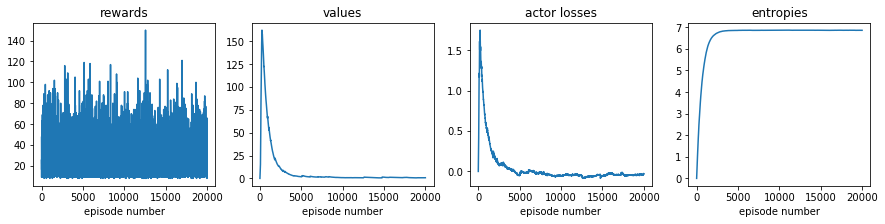

In [430]:
f, axes = plt.subplots(1, 4, sharey=False, figsize=(5 * 3, 3))
plt.subplot(1, 4, 1)
plt.plot(rewards_per_episode)
plt.title("rewards")
plt.xlabel("episode number")

plt.subplot(1, 4, 2)
plt.plot(average_value_per_episode)
plt.title("values")
plt.xlabel("episode number")

plt.subplot(1, 4, 3)
plt.plot(average_actor_loss_per_episode)
plt.title("actor losses")
plt.xlabel("episode number")

plt.subplot(1, 4, 4)
plt.plot(average_entropy_per_episode)
plt.title("entropies")
_ = plt.xlabel("episode number")

Different shared model architecture.

In [465]:
class ConvNet(Chain):
    
    def __init__(self, obs_size, n_units):
    
        super(ConvNet, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(None, 64, 3, pad=1)
            self.bn1 = L.BatchNormalization(64)
            self.conv2 = L.Convolution2D(64, 64, 3, pad=1)
            self.bn2 = L.BatchNormalization(64)
            
            self.fc1 = L.Linear(None, 2 * n_units)
            self.fc2 = L.Linear(2 * n_units, n_units)


    def __call__(self, x):

        h = F.relu(self.bn1(self.conv1(x)))
        h = F.relu(self.bn2(self.conv2(h)))
        h = F.max_pooling_2d(h, 2, 2)
        h = F.dropout(h, ratio=0.25)
        
        h = F.dropout(F.relu(self.fc1(h)), ratio=0.5)
        h = self.fc2(h)

        return h

Training on Breakout-v0.

In [ ]:
env = gym.make('Breakout-v0')
obs_size = env.observation_space.low.size
n_actions = env.action_space.n
n_units = 128
n_steps = 20
n_episodes = 20000

model = ActorCritic(shared_model=ConvNet(obs_size, n_units), n_actions=n_actions)
optimizer =chainer.optimizers.Adam()
optimizer.setup(model)
optimizer.add_hook(chainer.optimizer.GradientClipping(40))

frame_preprocessor = lambda x: (x.astype(np.float32) / 255.0).reshape((-1,) + x.shape)
agent = A2CAgent(model=model, optimizer=optimizer, gamma=0.99, n_steps=n_steps, phi=frame_preprocessor)

rewards_per_episode = []
average_value_per_episode = []
average_actor_loss_per_episode = []
average_entropy_per_episode = []

for i in range(1, n_episodes + 1):
    obs = env.reset()
    reward = 0
    done = False
    R = 0 
    t = 0
    while not done:
        # env.render()
        action = agent.act_and_train(obs, reward, done)
        obs, reward, done, _ = env.step(action)
        R += reward
        t += 1
    rewards_per_episode.append(R)
    average_value_per_episode.append(agent.get_statistics()[1][1])
    average_actor_loss_per_episode.append(agent.get_statistics()[0][1])
    average_entropy_per_episode.append(agent.get_statistics()[2][1])
    if i % 10 == 0:
        print('episode:', i,
              '| R:', R,
              '| statistics:', agent.get_statistics()
             )
    agent.stop_episode_and_train(obs, reward, done)

print('Finished.')

Statistic and reward plots.

In [ ]:
f, axes = plt.subplots(1, 4, sharey=False, figsize=(5 * 3, 3))
plt.subplot(1, 4, 1)
plt.plot(rewards_per_episode)
plt.title("rewards")
plt.xlabel("episode number")

plt.subplot(1, 4, 2)
plt.plot(average_value_per_episode)
plt.title("values")
plt.xlabel("episode number")

plt.subplot(1, 4, 3)
plt.plot(average_actor_loss_per_episode)
plt.title("actor losses")
plt.xlabel("episode number")

plt.subplot(1, 4, 4)
plt.plot(average_entropy_per_episode)
plt.title("entropies")
_ = plt.xlabel("episode number")